<a href="https://colab.research.google.com/github/JMML2021/Entrega-projecte-final/blob/main/3.b%20Companyia%20Aerea%20Algoritmes%20d%E2%80%99aprenentatge%20supervisat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Activo Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Abro el fichero
''' 
path = ('/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx')

    
df=  pd.read_csv(path, sep=',', encoding="latin-1")
df.shape

nRow, nCol = df.shape
print(f'Hay  {nRow} filas con {nCol} columnas')
df1=df.copy()
print('\nImprimo el primer registro, solo para ver como es:\n')
df1.iloc[0]
'''

' \npath = (\'/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx\')\n\n    \ndf=  pd.read_csv(path, sep=\',\', encoding="latin-1")\ndf.shape\n\nnRow, nCol = df.shape\nprint(f\'Hay  {nRow} filas con {nCol} columnas\')\ndf1=df.copy()\nprint(\'\nImprimo el primer registro, solo para ver como es:\n\')\ndf1.iloc[0]\n'

In [5]:
# Abrir fichero de Github.
#path='/content/drive/MyDrive/2022.06.03 2022_delay + cierre puertas CORTO.xlsx'
Hoja = 'FLT_2022'
path = ('/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx')

df = pd.read_excel(path) #, sheet_name=Hoja)


In [6]:
# Para crear una logistic regresion:

df['Tard1'] = np.where(df['Puntualidad1'] <10, 0, 1)
df['Tard2'] = np.where(df['Puntualidad2'] <10, 0, 1)
df['Tard3'] = np.where(df['Puntualidad3'] <10, 0, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12358 entries, 0 to 12357
Data columns (total 97 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Unnamed: 0                       12358 non-null  int64         
 1   DATE                             12358 non-null  datetime64[ns]
 2   FLT                              12358 non-null  object        
 3   REG                              12358 non-null  object        
 4   AC                               12358 non-null  object        
 5   DEP                              12358 non-null  object        
 6   ARR                              12358 non-null  object        
 7   STD                              12358 non-null  datetime64[ns]
 8   STA                              12358 non-null  datetime64[ns]
 9   TKof                             12358 non-null  datetime64[ns]
 10  TDwn                             12358 non-null  datetime6

In [8]:
df[['Puntualidad1','Tard1']][:3]

,Puntualidad1,Tard1
0,15.0,1
1,-22.0,0
2,3.0,0


In [9]:
df1=df[['Puntualidad1', 'Puntualidad2', 'Puntualidad3', 
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3', 'Tard1', 'Tard2', 'Tard3']]

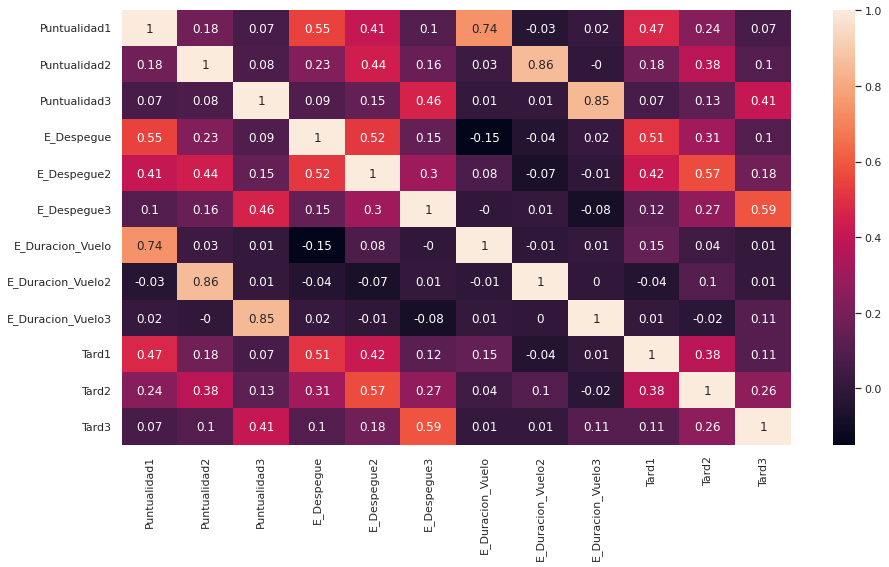

In [10]:
# Creo la matriz de correlacion entre todos los factores.

correlation_matrix = df1.corr().round(2) 
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=correlation_matrix, annot=True)

In [11]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

mapper = DataFrameMapper([(df1.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df1.copy(), 4)
df1_StdScaler= pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)

df1_StdScaler.head()

,Puntualidad1,Puntualidad2,Puntualidad3,E_Despegue,E_Despegue2,E_Despegue3,E_Duracion_Vuelo,E_Duracion_Vuelo2,E_Duracion_Vuelo3,Tard1,Tard2,Tard3
0,0.661875,0.158984,-0.020942,1.006091,0.398530,-0.039738,-0.022665,-0.049533,0.000086,2.979681,-0.387587,-0.362741
1,-0.620447,-0.405877,-0.020942,-0.939568,-0.840450,-0.655431,0.018437,0.025896,0.365863,-0.335606,-0.387587,-0.362741
2,0.245987,0.204173,-0.169253,0.340471,0.133034,-0.095710,0.018437,0.151611,-0.132924,-0.335606,-0.387587,-0.362741
3,0.800504,0.000823,-0.525200,1.159696,0.575527,-0.543487,0.018437,-0.326106,-0.265933,2.979681,-0.387587,-0.362741
4,0.176672,-0.134744,-0.050604,-0.222746,-0.530705,-0.263626,0.388352,0.151611,0.099843,-0.335606,-0.387587,-0.362741


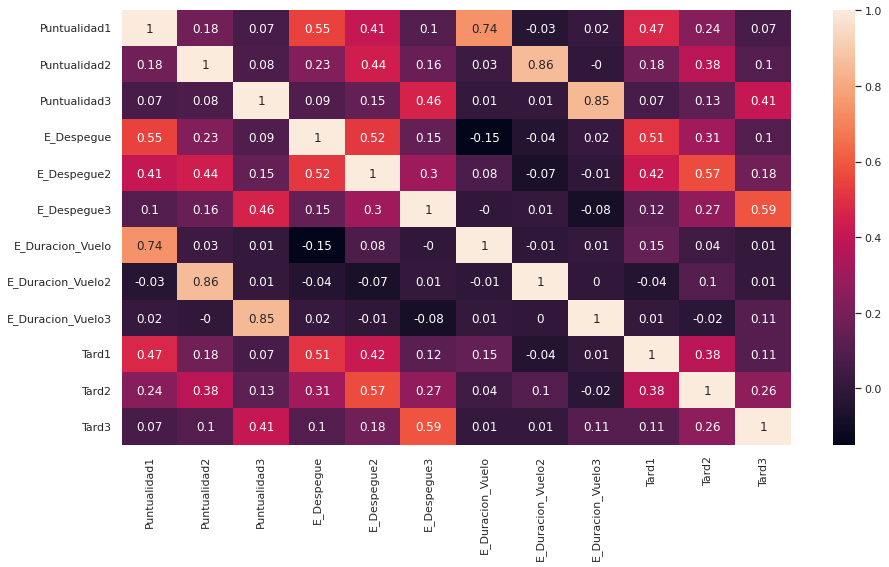

In [12]:
# Creo la matriz de correlacion entre todos los factores.

correlation_matrix = df1_StdScaler.corr().round(2) 
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=correlation_matrix, annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf4dac6d90>,
      dtype=object)

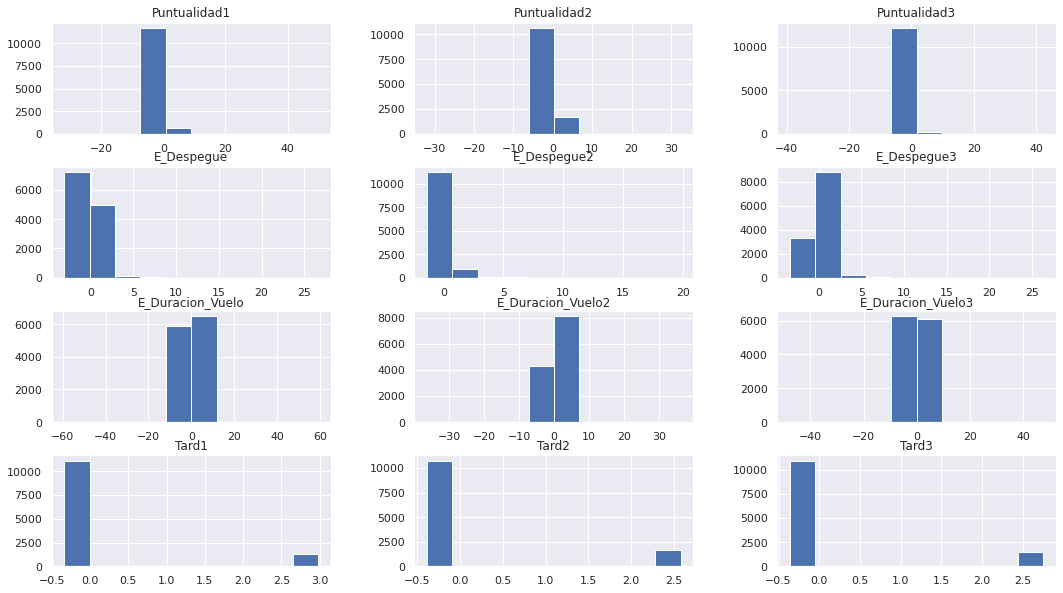

In [13]:
# Con los datos transformados veo si ha cambiado mucho la forma de cada variable
df1_StdScaler[df1_StdScaler.columns].hist(figsize=(18,10))

# Trec els outliers

In [14]:
df1.head()

,Puntualidad1,Puntualidad2,Puntualidad3,E_Despegue,E_Despegue2,E_Despegue3,E_Duracion_Vuelo,E_Duracion_Vuelo2,E_Duracion_Vuelo3,Tard1,Tard2,Tard3
0,15.0,4,-5,20,11,0.0,-5.0,-7,-5.0,1,0,0
1,-22.0,-21,-5,-18,-17,-11.0,-4.0,-4,6.0,0,0,0
2,3.0,6,-10,7,5,-1.0,-4.0,1,-9.0,0,0,0
3,19.0,-3,-22,23,15,-9.0,-4.0,-18,-13.0,1,0,0
4,1.0,-9,-6,-4,-10,-4.0,5.0,1,-2.0,0,0,0


In [15]:
# Elimino els outliers
df2=df1.copy()

dfEliminarOutliers= ((df2['E_Despegue']> -30) & 
                     (df2['E_Despegue']< 30) & 
                     (df2['Puntualidad1']< 30) & 
                     (df2['Puntualidad1']>-30) &
                     (df2['Puntualidad2']< 30) & 
                     (df2['Puntualidad2']>-30)&
                     (df2['E_Despegue2']< 30) & 
                     (df2['E_Despegue2']>-30)&
                     (df2['Puntualidad3']< 30) & 
                     (df2['Puntualidad3']>-30)&
                     (df2['E_Despegue3']< 30) & 
                     (df2['E_Despegue3']>-30))

df2 = df2[dfEliminarOutliers]

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10708 entries, 0 to 12357
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Puntualidad1       10708 non-null  float64
 1   Puntualidad2       10708 non-null  int64  
 2   Puntualidad3       10708 non-null  int64  
 3   E_Despegue         10708 non-null  int64  
 4   E_Despegue2        10708 non-null  int64  
 5   E_Despegue3        10708 non-null  float64
 6   E_Duracion_Vuelo   10708 non-null  float64
 7   E_Duracion_Vuelo2  10708 non-null  int64  
 8   E_Duracion_Vuelo3  10708 non-null  float64
 9   Tard1              10708 non-null  int64  
 10  Tard2              10708 non-null  int64  
 11  Tard3              10708 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 1.1 MB


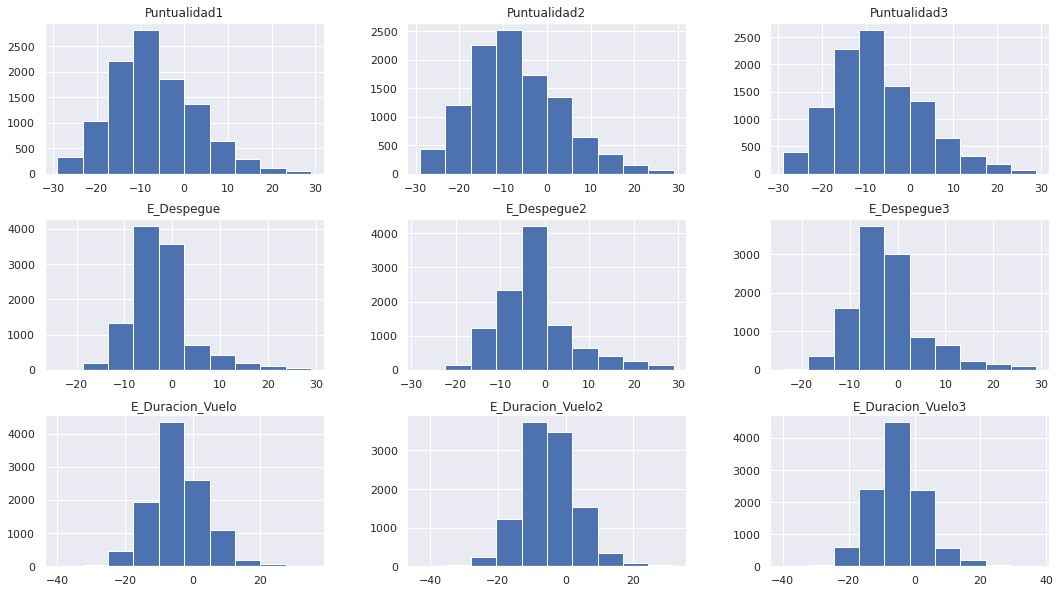

In [17]:
# Amb les dades transformades veig si ha canviat molt la forma de cada variable

ax= df2[df2.columns[:-3]].hist(figsize=(18,10))
 

Jose Manuel Castaño.

desbanceado = sampling 
Diferencia de accuracy y precision.

RobustScaler dummies
gradien boosting clasificaier
aplicar el cross validation
random forest e sbueno para los desbalanceados

finaldf= pd.concat([principal_Df,df[['target']]],axis=1)

# Unir de nuevo la variable objetivo

finalDf = pd.concat([principalDf, data[['target']]], axis = 1)
finalDf.head()

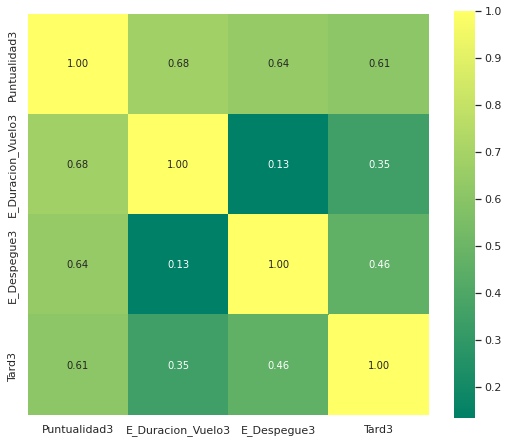

In [22]:
# Vull veure quines variables tenen més correlació respecte al target

columns_sorted = df2.corr().abs().nlargest(4, 'Puntualidad3').index
correlation_sorted = np.corrcoef(df2[columns_sorted].values.T)

f, ax = plt.subplots(figsize = (9,7.5))
hm = sns.heatmap(abs(correlation_sorted), annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns_sorted.values, xticklabels=columns_sorted.values, cmap='summer')
plt.show()

In [61]:
# Creo Subrutina de metricas:

#Importo scikit-learn metrics module para el calculo
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
metricasEjercicio2=[]
######################################################################
 
def MetricasModelo(metodo, Y_real, Y_calculado, scores):
  print('Metodo: ', metodo)
  
  #Precisión del modelo: ¿con qué frecuencia es correcto el clasificador?
  #accuracy = metrics.accuracy_score(Y_real, Y_calculado)
  #print("Accuracy:", accuracy)

  rmse = np.sqrt(mean_squared_error(Y_real, Y_calculado,))
  print("RMSE: %f" % (rmse))
  

  R_squared = r2_score(Y_real, Y_calculado,)

  print("R-Squared: ", np.round(R_squared, 2))
 
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  accuracy = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

  # Guardo metricas
  metricasEjercicio2.append([metodo, rmse, R_squared, accuracy])  


  cnf_matrix_SVM = metrics.confusion_matrix(Y_real, Y_calculado)

  print('\n\nMatriz de Confusión')
  print(cnf_matrix_SVM)


  # Creamos la Matriz de Confusion:

  class_names=[0,1] # name  of classes
  
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap

  sns.heatmap(pd.DataFrame(cnf_matrix_SVM), annot=True, cmap="gist_ncar" ,fmt='g')
  ax.xaxis.set_label_position("top")
 

  plt.tight_layout()
  plt.title('Matriu de confusió', y=1.1)
  plt.ylabel('Valor Actual')
  plt.xlabel('Valor predit')
  plt.Text(1.5,257.44,'Predicció')


# Creo les dates train i Test

In [25]:
df2

,Puntualidad1,Puntualidad2,Puntualidad3,E_Despegue,E_Despegue2,E_Despegue3,E_Duracion_Vuelo,E_Duracion_Vuelo2,E_Duracion_Vuelo3,Tard1,Tard2,Tard3
0,15.0,4,-5,20,11,0.0,-5.0,-7,-5.0,1,0,0
1,-22.0,-21,-5,-18,-17,-11.0,-4.0,-4,6.0,0,0,0
2,3.0,6,-10,7,5,-1.0,-4.0,1,-9.0,0,0,0
3,19.0,-3,-22,23,15,-9.0,-4.0,-18,-13.0,1,0,0
4,1.0,-9,-6,-4,-10,-4.0,5.0,1,-2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12353,-17.0,-6,-18,-11,-2,-8.0,-6.0,-4,-10.0,0,0,0
12354,-10.0,-23,5,-5,-9,2.0,-5.0,-14,3.0,0,0,0
12355,-4.0,3,-8,0,0,-2.0,-4.0,3,-6.0,0,0,0
12356,7.0,7,-10,5,16,-6.0,2.0,-9,-4.0,0,0,0


# Regresió logística

In [86]:
# Importo train_test_split function para dividir los datos en Test y Train
from sklearn.model_selection import train_test_split


datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2', 'Puntualidad3', 
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3', ]].values
        
datos_y = df2.loc[:,['Tard3']].values

#Dividimos el dataset en training set y test set
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test

In [27]:
# importar la libreria de regresion logistica 
from sklearn.linear_model import LogisticRegression

# instanciar el modelo (usando los parámetros predeterminados)
logreg = LogisticRegression()

# fit el modelo
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

In [28]:
# Borrar
print(y_pred_RLogis)

[0 0 0 ... 0 0 0]


In [29]:
#clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')
scores_RL = cross_val_score(logreg, X_train, y_train, cv=5)
 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RL.mean(), scores_RL.std() * 2))

Accuracy: 1.00 (+/- 0.00)


Metodo:  Regresion Logistica
RMSE: 0.000000
R-Squared:  1.0
Accuracy: 1.00 (+/- 0.00)


Matriz de Confusión
[[2998    0]
 [   0  215]]


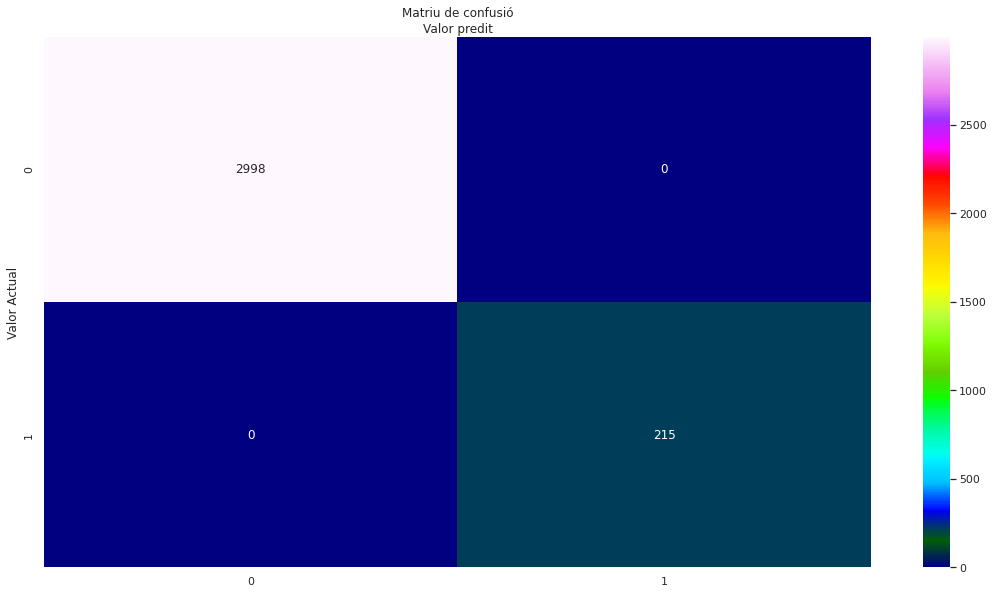

In [30]:
MetricasModelo( 'Regresion Logistica', y_test, y_pred_RLogis, scores_RL)

In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10708 entries, 0 to 12357
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Puntualidad1       10708 non-null  float64
 1   Puntualidad2       10708 non-null  int64  
 2   Puntualidad3       10708 non-null  int64  
 3   E_Despegue         10708 non-null  int64  
 4   E_Despegue2        10708 non-null  int64  
 5   E_Despegue3        10708 non-null  float64
 6   E_Duracion_Vuelo   10708 non-null  float64
 7   E_Duracion_Vuelo2  10708 non-null  int64  
 8   E_Duracion_Vuelo3  10708 non-null  float64
 9   Tard1              10708 non-null  int64  
 10  Tard2              10708 non-null  int64  
 11  Tard3              10708 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 1.1 MB


# Regresión logística con Python

https://www.cienciadedatos.net/documentos/py17-regresion-logistica-python.html

In [32]:
# Número de obsercaciones por clase
# ==============================================================================
df2['Tard3'].value_counts().sort_index()

0    9950
1     758
Name: Tard3, dtype: int64

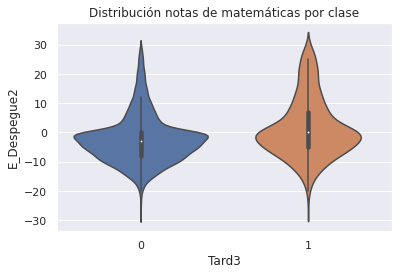

In [33]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'Tard3',
        y     = 'E_Despegue2',
        data  = df2,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribución notas de matemáticas por clase');

In [34]:
# T-test entre clases
# ==============================================================================
from statsmodels.stats.weightstats import ttest_ind


res_ttest = ttest_ind(
                x1 = df2[df2['Tard3'] == 0],
                x2 = df2[df2['Tard3'] == 1],
                alternative='two-sided'
            )
print(f"t={res_ttest[0]}, p-value={res_ttest[1]}")

t=[ -5.77871343 -16.04917848 -80.11127391  -5.19027346 -12.28435799
 -53.68011655  -2.60424274  -7.55066723 -38.44225611  -4.00824651
 -17.32743028         -inf], p-value=[7.73746383e-009 2.69313280e-057 0.00000000e+000 2.13832877e-007
 1.87447616e-034 0.00000000e+000 9.22047058e-003 4.68288738e-014
 5.53412092e-303 6.15859083e-005 2.33861384e-066 0.00000000e+000]


In [35]:
logreg = LogisticRegression()

# fit el modelo
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

In [80]:
# Importo train_test_split function para dividir los datos en Test y Train
from sklearn.model_selection import train_test_split

datos_x= df2.loc[:, ['E_Despegue2']].values
datos_y = df2.loc[:,['Tard3']].values

#Dividimos el dataset en training set y test set
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test

In [65]:
import statsmodels.api as sm

modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.660201
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7495
Model:                          Logit   Df Residuals:                     7494
Method:                           MLE   Df Model:                            0
Date:                Mon, 03 Oct 2022   Pseudo R-squ.:                  -1.540
Time:                        07:47:43   Log-Likelihood:                -4948.2
converged:                       True   LL-Null:                       -1948.1
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0633      0.003     21.044      0.000       0.057       0.069


In [66]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo.predict(exog = X_train)
predicciones[:4]

array([0.4841688 , 0.42147291, 0.60907408, 0.53163069])

In [39]:
# instanciar el modelo (usando los parámetros predeterminados)
logreg = LogisticRegression()

# fit el modelo
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

In [67]:
#clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')
scores_RL = cross_val_score(logreg, X_train, y_train, cv=5)
 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RL.mean(), scores_RL.std() * 2))

Accuracy: 0.93 (+/- 0.00)


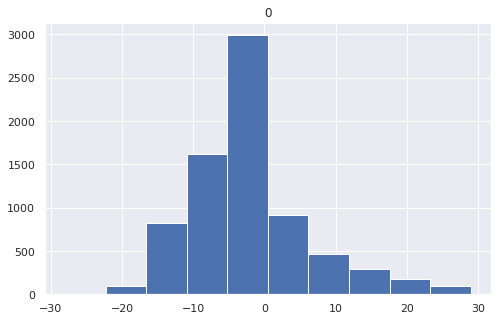

In [41]:
X_train= pd.DataFrame(X_train)
ax= X_train.hist(figsize=(8,5))

In [69]:
X_test.shape

(3213, 1)

In [68]:
# NO FUNCIONA


# Accuracy de test del model
# ==============================================================================
#X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 66.69779022720199%


In [91]:
#Borrar
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test
# instanciar el modelo (usando los parámetros predeterminados)
logreg = LogisticRegression()

# fit el modelo
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

In [95]:
# Predicciones en todo el rango de X
# ==============================================================================
# Se crea un vector con nuevos valores interpolados en el rango de observaciones.

grid_X = np.linspace(
            start = min(df2.E_Despegue2),
            stop  = max(df2.E_Despegue2),
            num   = 200
         ).reshape(-1,1)

grid_X = sm.add_constant(grid_X, prepend=True)
predicciones = modelo.predict()

AttributeError: ignored

In [81]:
 grid_X.shape

(200, 2)

borrar

y_pred_RLogis=logreg.predict(X_test)

In [93]:
# Creación del modelo
# ==============================================================================
# Para no incluir ningún tipo de regularización en el modelo se indica
# penalty='none'

modelo = logreg.predict(X_test)
#modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

In [84]:
X_test.shape

(3213, 1)

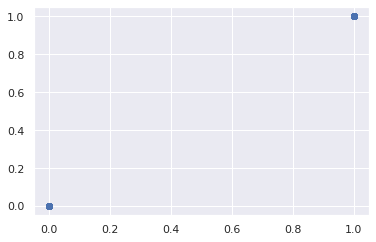

In [94]:
# BORRAR son pruebas
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.scatter(
   modelo,y_test)

ValueError: ignored

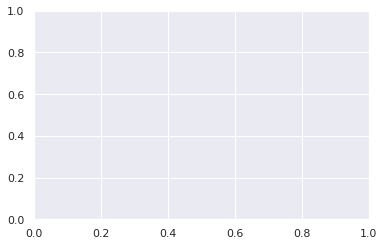

In [46]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.scatter(
   grid_X,y_test)
    #y_train)

ValueError: ignored

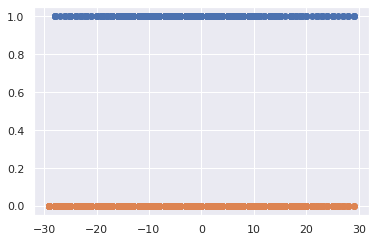

In [96]:
# Gráfico del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(
    X_train[(y_train == 1).flatten(), 1],
    y_train[(y_train == 1).flatten()].flatten()
)
ax.scatter(
    X_train[(y_train == 0).flatten(), 1],
    y_train[(y_train == 0).flatten()].flatten()
)
ax.plot(grid_X[:, 1], predicciones, color = "gray")
ax.set_title("Modelo regresión logística")
ax.set_ylabel("P(matrícula = 1 | matemáticas)")
ax.set_xlabel("Nota matemáticas");

ValueError: ignored

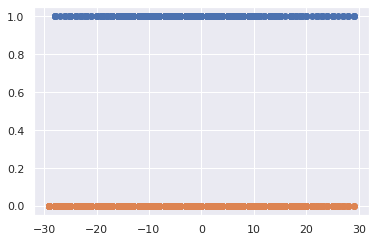

In [97]:
# Gráfico del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(
    X_train[(y_train == 1).flatten(), 1],
    y_train[(y_train == 1).flatten()].flatten()
)
ax.scatter(
    X_train[(y_train == 0).flatten(), 1],
    y_train[(y_train == 0).flatten()].flatten()
)
ax.plot(grid_X[:, 1], predicciones, color = "gray")
ax.set_title("Modelo regresión logística")
ax.set_ylabel("P(matrícula = 1 | matemáticas)")
ax.set_xlabel("Nota matemáticas");

In [ ]:
datos_x_2= df2.loc[:, ['E_Despegue3', 'E_Duracion_Vuelo3', 'Puntualidad2', 'Puntualidad3' ]].values


#Dividimos el dataset en training set y test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(datos_x_2, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test

# fit el modelo
logreg.fit(X_train_2,y_train_2)

#
y_pred_RLogis=logreg.predict(X_test_2)

#clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')
scores_RL = cross_val_score(logreg, X_train_2, y_train, cv=5)
 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RL.mean(), scores_RL.std() * 2))
MetricasModelo( 'Regre Log sin datos 1º salto', y_test, y_pred_RLogis, scores_RL)


In [ ]:
X_train_2=pd.DataFrame(X_train_2)
X_train_2.info()

In [ ]:
X_train_2.head()

# 2.- XGBoost 

In [ ]:
#scatter plots 
df3=df2[[   'E_Despegue3', 'E_Duracion_Vuelo3', 'Puntualidad2', 'Puntualidad3', 'Tard1?']]
 
g=sns.pairplot(df3,hue='Tard1?', palette='deep')
for ax in g.axes.ravel():
    ax.axvline(x=0, ls='--', linewidth=2, c='red') 
    ax.axvline(x=10, ls='-.', linewidth=1, c='green')

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
 
# X_train, X_test, y_train, y_test
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [ ]:

datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2', 'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3', ]].values
datos_y = df2.loc[:,['Puntualidad3']].values

#Dividimos el dataset en training set y test set
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test

In [ ]:
# Creo el modelo:
 
xg_reg = xgb.XGBClassifier(objective="multi:softprob",  n_classes=3)

xg_reg.fit(X_train,y_train)

y_preds_XGBoost = xg_reg.predict(X_test)
y_preds_XGBoost 

In [ ]:
scores_SGB = cross_val_score(xg_reg, X_train, y_train, cv=5)
MetricasModelo( 'XGBoost', y_test, y_preds_XGBoost, scores_SGB)

## 4.- Utilizando Multinomial logistic regression

In [ ]:
log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
log_reg.fit(X_train, y_train)
y_pred_MLR = log_reg.predict(X_test)

In [ ]:
scores_RLM = cross_val_score(log_reg, X_train, y_train, cv=5)

In [ ]:
MetricasModelo( 'Mult. logistic regression', y_test, y_pred_MLR, scores_RLM )

# 3.- Gestió unbalance dataset

https://elitedatascience.com/imbalanced-classes

## Regressió Logística Balanceada

### 1. Up-sample Minority Class

In [47]:
# Número de obsercaciones por clase
# ==============================================================================
df2['Tard3'].value_counts().sort_index()

0    9950
1     758
Name: Tard3, dtype: int64

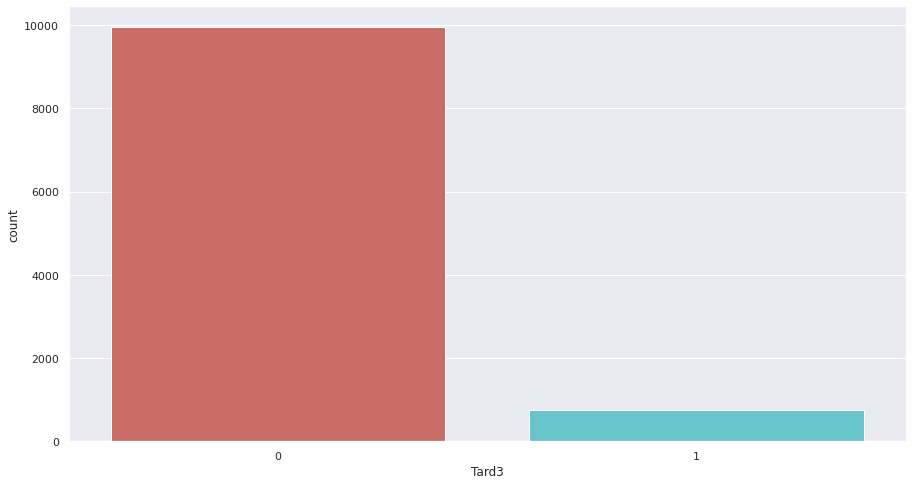

In [48]:
sns.countplot(x='Tard3',data=df2, palette='hls')
plt.show()

In [49]:
df2.columns

Index(['Puntualidad1', 'Puntualidad2', 'Puntualidad3', 'E_Despegue',
       'E_Despegue2', 'E_Despegue3', 'E_Duracion_Vuelo', 'E_Duracion_Vuelo2',
       'E_Duracion_Vuelo3', 'Tard1', 'Tard2', 'Tard3'],
      dtype='object')

In [101]:
from sklearn.utils import resample



# Separate majority and minority classes
df_majority = df2[df2.Tard3==0]
df_minority = df2[df2.Tard3==1]
 
# Upsample minority class
df_minority_sobremostrejat = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with sobremostrejat minority class
df2_sobremostrejat = pd.concat([df_majority, df_minority_sobremostrejat])
 
# Display new class counts
df2_sobremostrejat.Tard3.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

0    9950
1    8000
Name: Tard3, dtype: int64

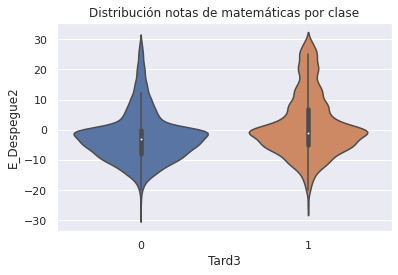

In [102]:
fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'Tard3',
        y     = 'E_Despegue2',
        data  = df2_sobremostrejat,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribución notas de matemáticas por clase');

Accuracy: 1.00 (+/- 0.00)
Metodo:  Regr.Log. Balanceada
RMSE: 0.000000
R-Squared:  1.0
Accuracy: 1.00 (+/- 0.00)


Matriz de Confusión
[[3009    0]
 [   0 2376]]


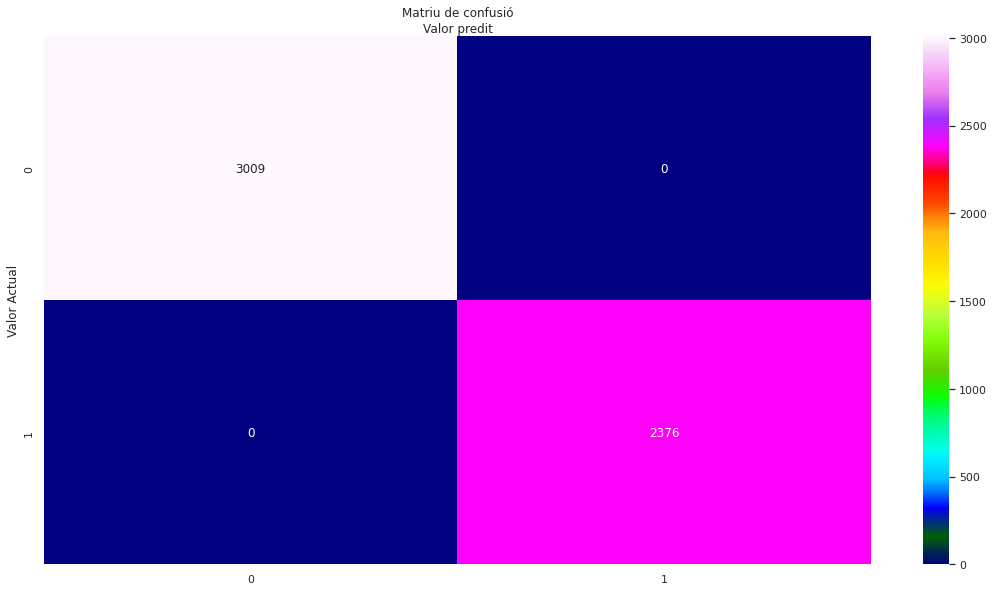

In [104]:
# Importo train_test_split function para dividir los datos en Test y Train
from sklearn.model_selection import train_test_split


# Creo la columna X e Y:
#datos_x = df2.loc[:,data.columns != 'target'].values

datos_x= df2_sobremostrejat.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3','E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values

datos_y = df2_sobremostrejat.loc[:,['Tard3']].values

#Dividimos el dataset en training set y test set
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test


# instanciar el modelo (usando los parámetros predeterminados)
logreg = LogisticRegression()

# fit el modelo
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

scores_RL = cross_val_score(logreg, X_train, y_train, cv=5)
 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RL.mean(), scores_RL.std() * 2))


MetricasModelo( 'Regr.Log. Balanceada', y_test, y_pred_RLogis, scores_RL)



In [105]:
a = datos_y.reshape(-1,1)
a

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

## regresión logística múltiple

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [107]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo

import statsmodels.api as sm

# División de los datos en train y test
# ==============================================================================
datos_x= df2_sobremostrejat.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 

X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )




# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo



In [108]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(y_train, X_train,)
modelo = modelo.fit()
print(modelo.summary())

         Current function value: inf
         Iterations: 35


LinAlgError: ignored

# 3.- Regresion Logistica Balanceada Binomial

In [109]:
df2_sobremostrejat.shape

(17950, 12)

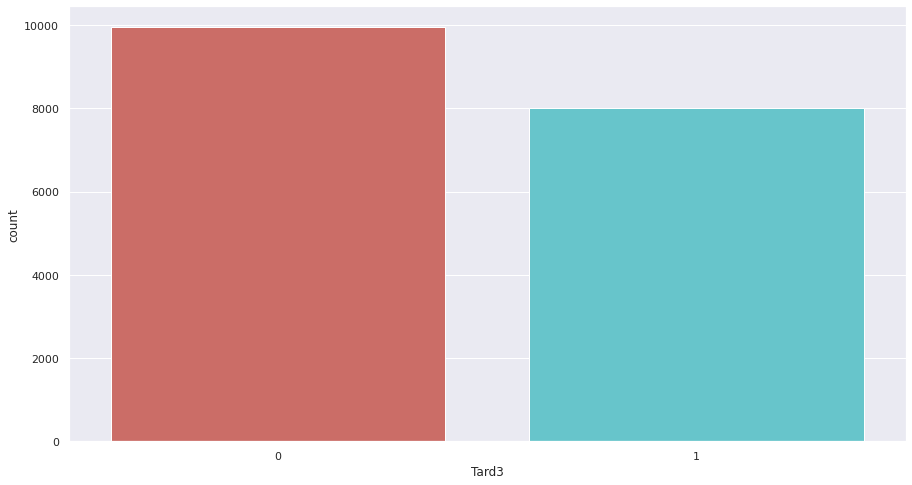

In [110]:
sns.countplot(x='Tard3',data=df2_sobremostrejat, palette='hls')
plt.show()

In [121]:
datos_x= df2_sobremostrejat.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]]

datos_y = df2_sobremostrejat.loc[:,['Tard3']]

https://www.statsmodels.org/stable/index.html

In [122]:
import statsmodels.api as sm

logit_model=sm.Logit( datos_y, datos_x)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.147017
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.786    
Dependent Variable: Tard3            AIC:              5289.9023
Date:               2022-10-03 08:16 BIC:              5336.6744
No. Observations:   17950            Log-Likelihood:   -2639.0  
Df Model:           5                LL-Null:          -12336.  
Df Residuals:       17944            LLR p-value:      0.0000   
Converged:          0.0000           Scale:            1.0000   
No. Iterations:     35.0000                                     
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Puntualidad1        0.0653      nan     nan    nan    nan    nan
Puntualidad2        0.0276      nan     nan    nan    nan    nan
E_Despegue          0.0240      nan     nan    nan    nan    nan
E_Despegue2        -0.0475      nan     nan    nan

**Qué diferencia** hay entre print(results.summary()) y print(results.summary2())

In [123]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                17950
Model:                          Logit   Df Residuals:                    17944
Method:                           MLE   Df Model:                            5
Date:                Mon, 03 Oct 2022   Pseudo R-squ.:                  0.7861
Time:                        08:17:01   Log-Likelihood:                -2639.0
converged:                      False   LL-Null:                       -12336.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Puntualidad1          0.0653        nan        nan        nan         nan         nan
Puntualidad2          0.0276        nan        nan        nan         nan         nan
E_Despegue            0.

In [126]:
cols=['E_Despegue3', 'E_Duracion_Vuelo3']
#cols=['E_Despegue3'] # Per crear una mica error
X=datos_x[cols]
y=datos_y


logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.194775
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.717    
Dependent Variable: Tard3            AIC:              6996.4355
Date:               2022-10-03 08:19 BIC:              7012.0262
No. Observations:   17950            Log-Likelihood:   -3496.2  
Df Model:           1                LL-Null:          -12336.  
Df Residuals:       17948            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
E_Despegue3         0.2857   0.0047 61.0477 0.0000 0.2765 0.2948
E_Duracion_Vuelo3   0.3126   0.0056 56.2014 0.0000 0.3017 0.3235



In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#logreg = LogisticRegression()
#logit_model.fit(X_train, y_train)


logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())




Optimization terminated successfully.
         Current function value: 0.193130
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.719    
Dependent Variable: Tard3            AIC:              4857.3689
Date:               2022-10-03 08:30 BIC:              4872.2463
No. Observations:   12565            Log-Likelihood:   -2426.7  
Df Model:           1                LL-Null:          -8626.8  
Df Residuals:       12563            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
E_Despegue3         0.2866   0.0056 51.3298 0.0000 0.2756 0.2975
E_Duracion_Vuelo3   0.3214   0.0069 46.7525 0.0000 0.3080 0.3349



In [143]:
 
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


### Confusion Matrix

In [144]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2948    0]
 [   0 2437]]


In [145]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2948
           1       1.00      1.00      1.00      2437

    accuracy                           1.00      5385
   macro avg       1.00      1.00      1.00      5385
weighted avg       1.00      1.00      1.00      5385



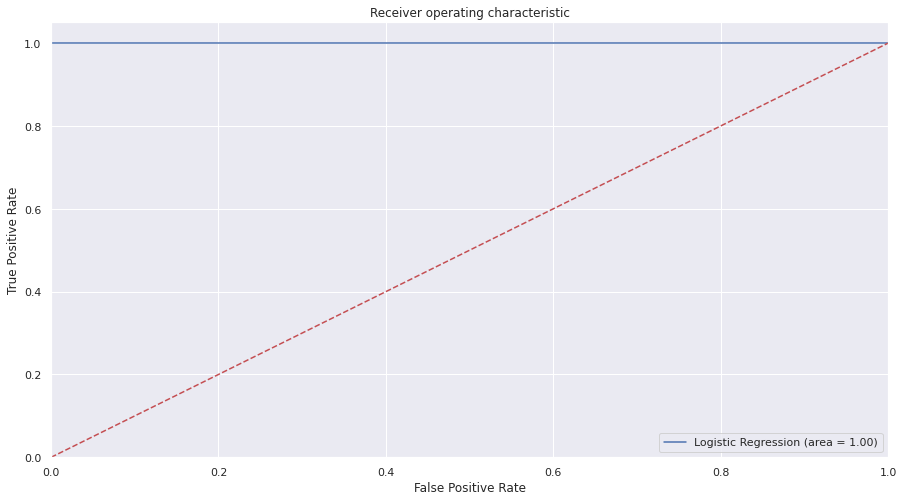

In [130]:
#@title roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Metodo:  Regr.Log. Balanceada Binomial
RMSE: 0.706121
R-Squared:  -1.01
Accuracy: 1.00 (+/- 0.00)


Matriz de Confusión
[[1636 1312]
 [1373 1064]]


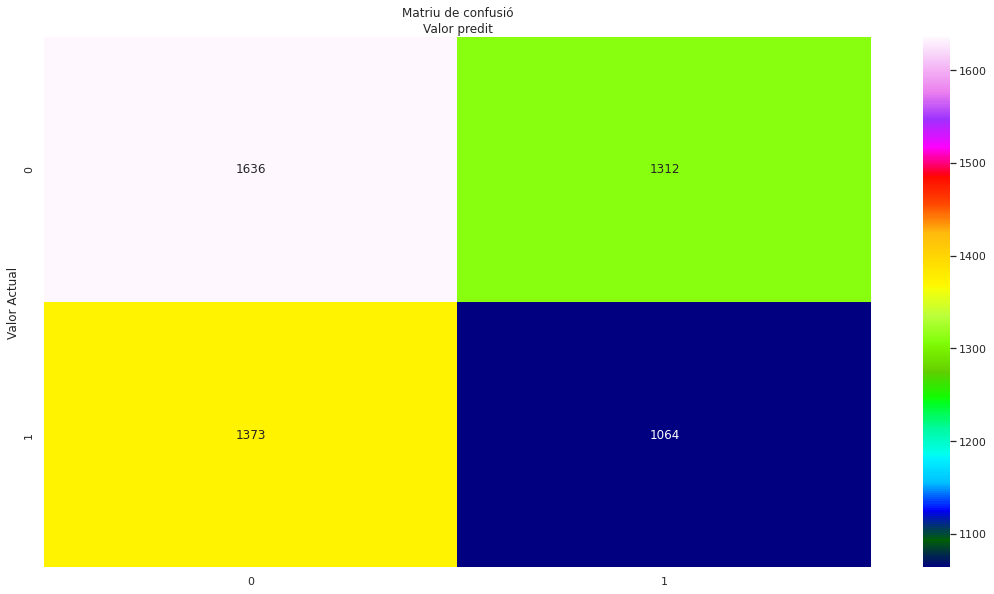

In [146]:
MetricasModelo( 'Regr.Log. Balanceada Binomial', y_test, y_pred_RLogis, scores_RL)



---



Busquem la correlacion entre variables 'E_Despegue3' i 'E_Duracion_Vuelo3', i el tamany que és en funció del temps de retard.

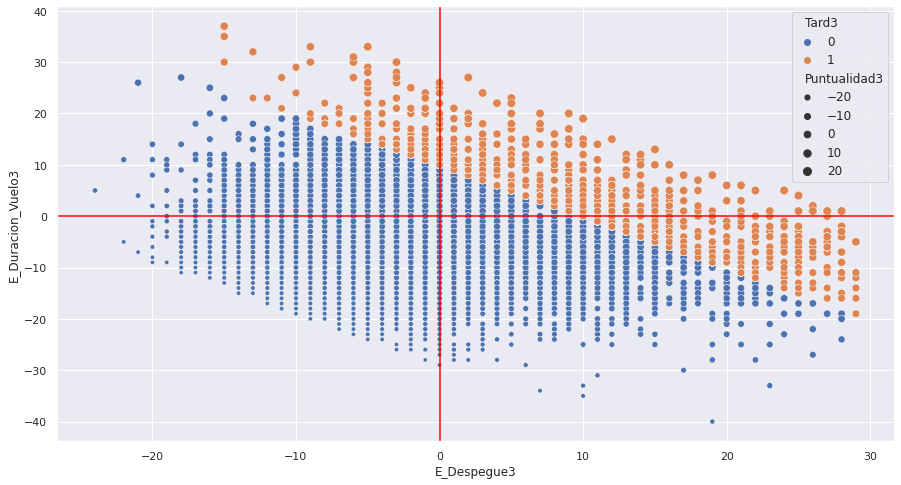

In [120]:
ax= sns.scatterplot(data = df2_sobremostrejat, x = 'E_Despegue3',  y = 'E_Duracion_Vuelo3', hue = "Tard3", size ='Puntualidad3')
ax.axvline(0, color='red')
ax.axhline(0, color='red')